# Dependencies and libraries 

In [105]:
import cobra
import re
from pprint import pprint
import pandas as pd
import numpy as np
import copy
import os 
import sklearn 
import matplotlib.pyplot as plt



In [106]:
os.chdir('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation')
print(os.getcwd())

mitocore = cobra.io.read_sbml_model("Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml")
human1 = cobra.io.read_sbml_model("Human-GEM.xml")

os.chdir('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Human1_coverage/KEGG_Modules')
print(os.getcwd())

/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation
/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Human1_coverage/KEGG_Modules


In [ ]:
def sort_kegg_ids (model,target_db):
    """Extract reaction id for a target database from a defined model, if >1 id 
    add all ids as new entries.

    model: COBRApy model (not an .xml file but already loaded as a model)
    target_db: database key in the annotations of the model
    """
    import re
    pattern=r'R\d{5}' #Pattern KEGG ids recognition (e.g. R00209)

    kegg_react={'model_id':[], target_db:[]}

    #get reaction annotations from an object (loaded model)
    reactions= getattr(model , 'reactions')
    for reaction in reactions:
        target_id=reaction.annotation.get(target_db)

         # Normalize annotation value to string
        if isinstance(target_id, list):
            target_id = ' '.join(target_id)
        else:
            target_id = str(target_id)

        # Find all KEGG ids (e.g. R00209, R01324, etc.)
        matches = re.findall(pattern, target_id) #re.findall() works just with str
        for match in matches:
            kegg_react['model_id'].append(reaction.id)
            kegg_react[target_db].append(match)

    return pd.DataFrame.from_dict(kegg_react)

def kegg_API_req(model,input_df,input_id, target ,target_rest, split_pat):
    """ Function to perform KEGG API request
    model: str, name of the model of interest
    input_df: dataframe with KEGG ids.
    target_db: target in KEGG to look for, position [0]. (e.g. 'kegg.module', 'kegg.reaction')
    target_rest: residue in the same line of target_db, position [1]. 
    split_pat: pattern to split when processing response. (e.g. 'PATHWAY', 'MODULE')
    """
    import pandas as pd
    import ssl  # certificates needed to access KEGG API 
    from urllib import request  

    output_dict = {'model_id': [], target: [], target_rest: []}
    ssl._create_default_https_context = ssl._create_unverified_context #create the certificate

    kegg_attr = list(input_df.loc[:,input_id])
    model_id = list(input_df.loc[:,'model_id'])


    batch_size = 10

    counter = 0

    for batch in range(0, len(kegg_attr), batch_size):

        url = 'https://rest.kegg.jp/get/'
        batch_index = 0
        batch_entries = []
        
        while(batch + batch_index < len(kegg_attr) and batch_index < batch_size):
            
            batch_entries.append(kegg_attr[batch + batch_index])
            url += kegg_attr[batch + batch_index]
            
            if batch_index < batch_size-1:
                url+='+'
            
            batch_index += 1

        req = request.Request(url)
        with request.urlopen(req) as f:
            response = f.read()
        response_string_list = response.decode('utf-8').splitlines()

        reading_pathway_section = False
        gene_has_pathways = False

        entry_index = 0

        for line in response_string_list:

            if line == '///':
                if not gene_has_pathways:
                    output_dict['model_id'].append(model_id[counter])
                    output_dict[target].append('')
                    output_dict[target_rest].append('')

                print('attr:', counter + 1, 'of', len(kegg_attr), end='\r')

                entry_index += 1
                counter += 1
                reading_pathway_section = False
                gene_has_pathways = False
                continue
            
            if reading_pathway_section and not line.startswith(' '):
                reading_pathway_section = False

            if line.startswith(split_pat):
                reading_pathway_section = True
                gene_has_pathways = True
                line = line.split(split_pat)[1]
            
            if reading_pathway_section:
                line_split = line.strip().split('  ')

                output_dict['model_id'].append(model_id[counter])
                output_dict[target].append(line_split[0])
                output_dict[target_rest].append(line_split[1])

        
        
    return pd.DataFrame.from_dict(output_dict).to_csv(f"{target}_{model}.csv", index=False)

def sort_kegg_ids_human1 (model,target_db ):
    """Extract reaction id for a target database from human1, if >1 id 
    add all ids as new entries.

    -model: COBRApy model 
    -target_db: database key in the annotations of the model
    """
    import re
    pattern=r'R\d{5}'

    kegg_react={'model_id':[], target_db:[]}

    reactions= getattr(model , 'reactions')
    for ann in reactions:
        #human1_c_e_m is a list with all reactions in compartments c,e,m 
        if ann in human1_c_e_m: 
            target_id=ann.annotation.get(target_db)

            # Normalize annotation value to string
            if isinstance(target_id, list):
                target_id = ' '.join(target_id)
            else:
                target_id = str(target_id)

            # Find all KEGG IDs (e.g., R00209, R01324, etc.)
            matches = re.findall(pattern, target_id) #re.findall() works just with str
            for match in matches:
                kegg_react['model_id'].append(ann.id)
                kegg_react[target_db].append(match)

    return pd.DataFrame.from_dict(kegg_react)

def extract_modules(modes_model1,modes_model2):
    """function to extract all the modules for 2 models.

    -modes_model1: .csv file with modes from model 1.
    -modes_model2: .csv file with modes from model 2

    returns: dataframe with all modules from both models (2 columns: module id, module name)
    """

    modules_total={'module':[], 'module name':[]}
    for index, row in modes_model1.iterrows():
        module= row['kegg.module']
        name= row['module_name']

        if pd.notna(module):
            modules_total['module'].append(module)
            modules_total['module name'].append(name)

    for index, row in modes_model2.iterrows():
        module= row['kegg.module']
        name= row['module_name']

        if pd.notna(module):
            modules_total['module'].append(module)
            modules_total['module name'].append(name)

    return pd.DataFrame(modules_total)

def kegg_API_modul_content(input_df, input_id, target):
    """ Function to perform KEGG API request to obtain all KEGG reactions contained in a KEGG module
   
    -input_df: dataframe with KEGG module ids.
    -target_db: name of column with modules in input_df
    -target: target (whole reaction response per module)

    returns: dataframe with all reactions per module (2 columns: module id, whole content of the module (reactions, compounds, enzymes))
    """
    
    import pandas as pd
    import ssl  # certificates needed to access KEGG API 
    from urllib import request  

    output_dict = {'module_id': [], target: []}
    ssl._create_default_https_context = ssl._create_unverified_context  # create the certificate

    kegg_attr = list(input_df.loc[:, input_id])
    batch_size = 10

    for batch in range(0, len(kegg_attr), batch_size):

        url = 'https://rest.kegg.jp/get/'
        batch_index = 0
        batch_entries = []
        
        while (batch + batch_index < len(kegg_attr) and batch_index < batch_size):
            entry = kegg_attr[batch + batch_index]
            batch_entries.append(entry)
            url += entry
            if batch_index < batch_size - 1:
                url += '+'
            batch_index += 1

        req = request.Request(url)
        with request.urlopen(req) as f:
            response = f.read()
        response_string_list = response.decode('utf-8').splitlines()

        collecting_reactions = False
        reaction_buffer = []

        for line in response_string_list:
            if line.startswith("ENTRY"):
                current_module = line.split()[1]

            elif line.startswith("REACTION") and current_module is not None:
                collecting_reactions = True
                # start after "REACTION"
                reaction_buffer.append(line[len("REACTION"):].strip())

            elif collecting_reactions:
                if line.startswith(("COMPOUND", "ENZYME", "NAME", "ENTRY", "CLASS")):
                    # stop collecting
                    collecting_reactions = False
                    result = " ".join(reaction_buffer).strip()
                    output_dict['module_id'].append(current_module)
                    output_dict[target].append(result)
                    reaction_buffer = []
                else:
                    # continuation line
                    reaction_buffer.append(line.strip())
        
    df = pd.DataFrame.from_dict(output_dict)
    df.to_csv("modules_content.csv", index=False)
    return df

def module_coverage_index(csv_reactions_model, dict_with_modules_react, csv_modules_model):
    """ function to calculate the coverage index of a model based on KEGG modules

    -csv_reactions_model: .csv file with all reactions in the model and the rreactions KEGG ids
    -dict_with_modules_react: dictionary with all modules as key and all reactions of the module as values
         dict {'M00549': ['R01786, R02189, R00959, R00289']}
    -csv_modules_model: .csv file with all modules in the model 

    returns: dataframe with coverage index per module (2 columns: module id, coverage index)
    """
    import re
    
    # read csv with reactions and modules in model
    reactions_mod = pd.read_csv(csv_reactions_model)  
    modules_model = pd.read_csv(csv_modules_model)
    # avoid duplicate module ids from the csv file 
    modules_model_ids = list(modules_model['kegg.module'].unique())

    # discard duplicates from the reactions list
    reactions = list(set(reactions_mod['kegg.reaction']))
    modules = dict_with_modules_react
    #open collecting dict
    coverage_dict = { 'module id': [], 'module name': [], 'coverage': []}

    # loop over modules in list of modules from the model
    for module_id in modules_model_ids:
        # check if module is in mapping dict
        if module_id in modules:

            name_series = modules_model.loc[modules_model['kegg.module'] == module_id, 'module_name']
            name = name_series.values[0] if len(name_series) > 0 else 'Unknown'
            # normalize stored value into a list of R00000 ids
            raw = modules[module_id]
            if isinstance(raw, str):
                react_in_module = re.findall(r'R\d{5}', raw)
            elif isinstance(raw, (list, tuple)):
                # join then extract (handles list of one id or list of ids as str)
                joined = " ".join(str(x) for x in raw)
                react_in_module = re.findall(r'R\d{5}', joined)
            else:
                # make a list out of it
                try:
                    react_in_module = list(raw)
                except Exception:
                    react_in_module = []
            #calculate total number of reactions in a module 100%
            total_react_in_module = len(react_in_module)
            print(f"module {module_id} has {total_react_in_module} reactions")
            # handle cases of empty modules
            if total_react_in_module == 0:
                coverage_dict['module id'].append(module_id)
                coverage_dict['module name'].append(name)
                coverage_dict['coverage'].append(0)
                continue
            # count how many reactions from the module are in the model
            react_set = set(react_in_module)
            counter = sum(1 for reaction in reactions if reaction in react_set)
            coverage = counter / total_react_in_module

            # store coverage ratio once per module
            coverage_dict['module id'].append(module_id)
            coverage_dict['module name'].append(name)
            coverage_dict['coverage'].append(coverage)
            
    return pd.DataFrame(coverage_dict)

# Obtain KEGG Modules based on KEGG ids
1. Extract KEGG ids from Mitoocore and Mitocore ids into dataframe
2. Api request to obtain KEGG modules for this KEGG ids


In [ ]:
# 1. Processing Mitocore KEGG ids calling functions
kegg_mito=sort_kegg_ids(mitocore,'kegg.reaction')
print('lenght: ', len(kegg_mito))
pd.DataFrame(kegg_mito).to_csv('kegg_reactions_mito.csv')

# 2. API calling function
kegg_API_req('mitocore', kegg_mito,'kegg.reaction', 'kegg.module','module_name', 'MODULE')



lenght:  360


# Processing Human1 reactions

1. Extract just reactions from (Cytosol, Extracelular,Mitochondria) to make Human1 comparable to Mitocore
2. KEGG ids from Mitoocore and Mitocore ids into dataframe
3. Api request to obtain KEGG modules for this KEGG ids and save into csv
4. Read csv file and extract modules from models into array
5. Presence-absence array per KEGG modules
6. Plot presence-absence map


In [109]:
# 1.Extract just reactions from c,e,m compartments)
allowed = {'c', 'm', 'e'}
human1_c_e_m = [
    reaction for reaction in human1.reactions
    if {met.compartment for met in reaction.metabolites}.issubset(allowed)
]
print(len(human1_c_e_m))

9612


In [110]:
# 2. KEGG ids from Mitoocore and Mitocore ids into dataframe
kegg_human1=sort_kegg_ids_human1 (human1,'kegg.reaction')
print('lenght: ', len(kegg_mito))

df_human1 = kegg_human1[kegg_human1['kegg.reaction'].notna()]
print('lenght: ', len(kegg_human1))


lenght:  360
lenght:  1850


In [ ]:
# 3. API request to obtain KEGG modules for this KEGG ids
pd.DataFrame(df_human1).to_csv('kegg_reactions_human1.csv')
kegg_API_req('human1',df_human1,'kegg.reaction', 'kegg.module','module_name', 'MODULE')

In [ ]:
# 4. read modules for Mitocore and Human1 from API request 
modules_mito= pd.read_csv('kegg.module_mitocore.csv')
modules_human1= pd.read_csv('kegg.module_human1.csv')

# dataframe with all modules Mitocore, Human1 drop duplicates
total_modules= extract_modules(modules_mito,modules_human1)
total_modules= total_modules.drop_duplicates()
print(total_modules)

      module                                        module name
0     M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...
1     M00549               UDP-Glc biosynthesis, Glc => UDP-Glc
3     M00002  Glycolysis, core module involving three-carbon...
4     M00003       Gluconeogenesis, oxaloacetate => fructose-6P
5     M00165   Reductive pentose phosphate cycle (Calvin cycle)
...      ...                                                ...
1350  M00897  Thiamine biosynthesis, plants, AIR (+ NAD+) =>...
1351  M00898  Thiamine biosynthesis, pyridoxal-5P => TMP/thi...
1355  M00124  Pyridoxal-P biosynthesis, erythrose-4P => pyri...
1356  M00103                       Cholecalciferol biosynthesis
1376  M00538           Toluene degradation, toluene => benzoate

[217 rows x 2 columns]


In [ ]:
# 5. KEGG module presence-absence array 
#dictionary, catch flags in modules for the respective model
mitocore_flags = []
human1_flags = [] 

# discard duplicates from the modules
mito_modules = set(modules_mito['kegg.module'])
human1_modules = set(modules_human1['kegg.module'])

#extract 'modules' row from df for all modules (Humanq1 + Mitocore)
for index, row in total_modules.iterrows():
    module = row['module']
    #conditional = 1 if module in total modules in Mitocore or Human1 
    mitocore_flags.append(1 if module in mito_modules else 0)
    human1_flags.append(1 if module in human1_modules else 0)

# Add new columns to dataframe
total_modules['Mitocore'] = mitocore_flags
total_modules['Human1'] = human1_flags



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20

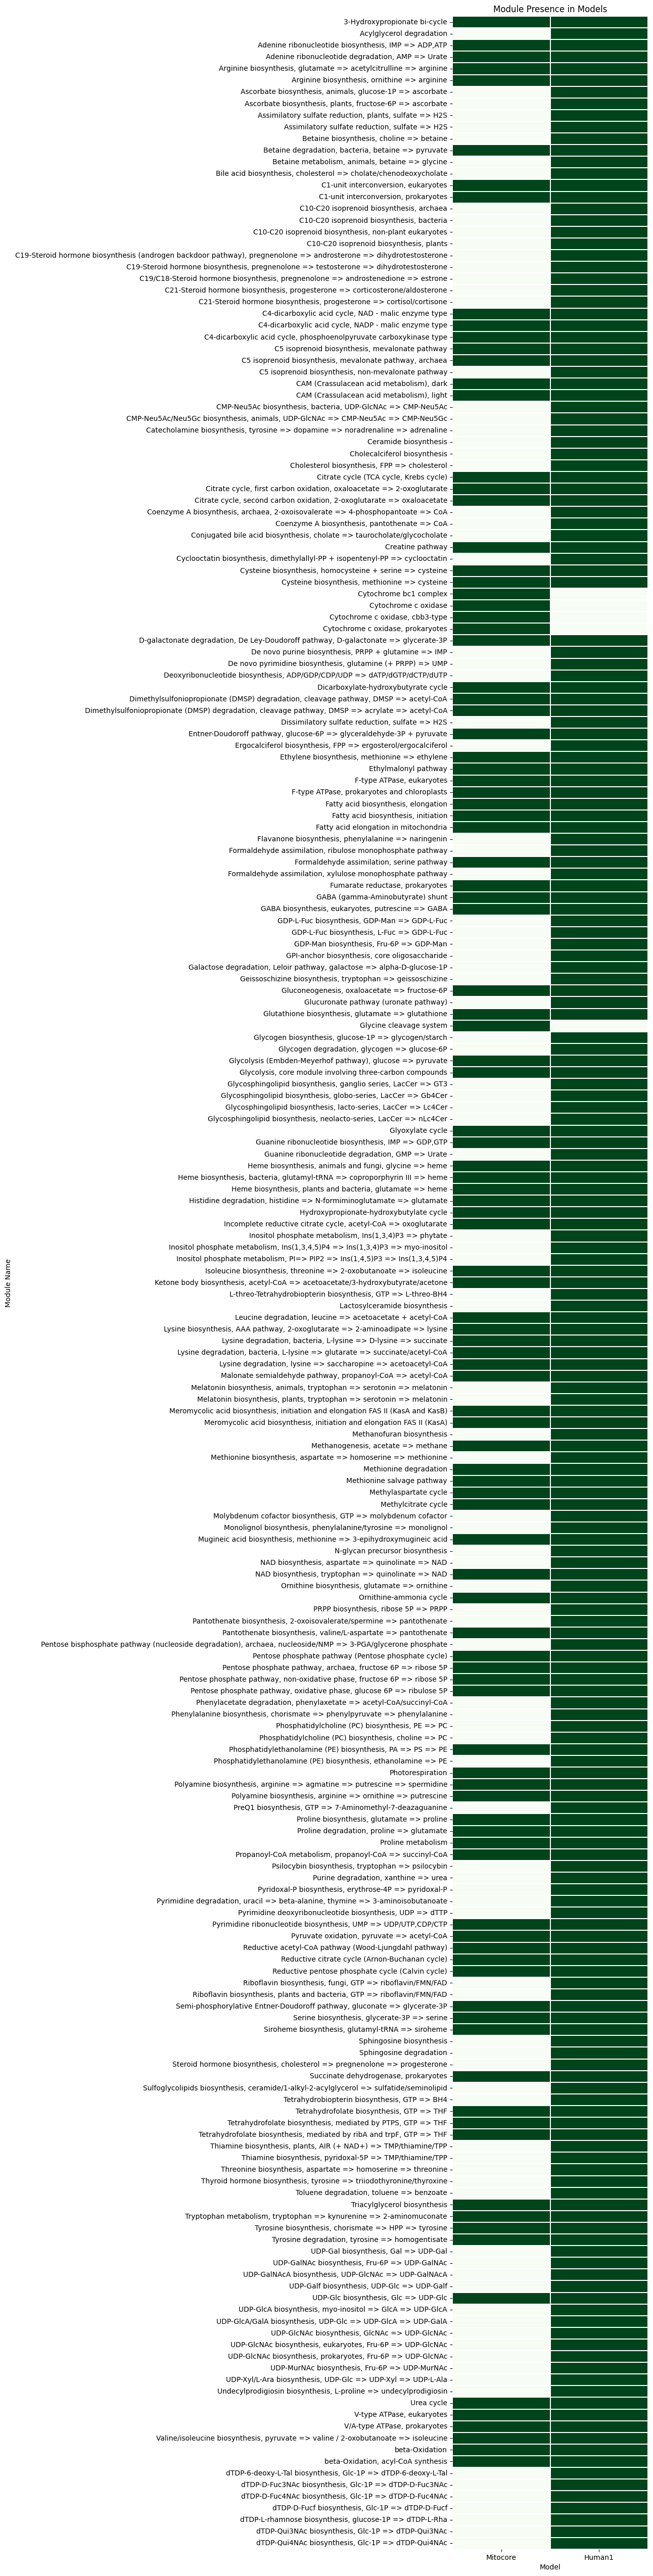

In [ ]:
# 6. Plot presence-absence map
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
print(plt.colormaps())

heatmap_data = total_modules.set_index('module name')[['Mitocore', 'Human1']].sort_index(axis=0)

# Create the heatmap
plt.figure(figsize=(5, len(heatmap_data) * 0.3))  # Adjust height to number of modules
sns.heatmap(heatmap_data, cmap='Greens', cbar=False, linewidths=0.1)

plt.title('Module Presence in Models')
plt.xlabel('Model')
plt.ylabel('Module Name')
#plt.tight_layout()
plt.show()

# KEGG Module coverage per model as Heatmap 

1. Create dataframe with all modules (Human1 + Mitocore)
2. API request for KEGG modules
3. Create dictionary with module as key and all reactions as values such as --> {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
4. Plot coverage index




In [ ]:
modules_total = list(total_modules['module'])
modules_total_df = pd.DataFrame(modules_total, columns=['module'])
print(modules_total_df)

     module
0    M00001
1    M00549
2    M00002
3    M00003
4    M00165
..      ...
212  M00897
213  M00898
214  M00124
215  M00103
216  M00538

[217 rows x 1 columns]


In [92]:
# 2. API request for KEGG modules
Modules_response=kegg_API_modul_content(modules_total_df, 'module', 'reactions')

In [115]:
# 3. Create dictionary with strcture
#  {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
module_reactions = pd.read_csv('modules_content.csv') 

import re
pattern = r'R\d{5}'  # Pattern KEGG ids recognition (e.g. R00209)
modules_dict = {}

for index, row in module_reactions.iterrows():
    module = row['module_id']
    reactions = row['reactions']
    matches = re.findall(pattern, reactions)  # re.findall() works just with str
    if matches:
        if module not in modules_dict:
            modules_dict[module] = []  # Initialize the list for the module
        modules_dict[module].append(', '.join(matches))  # Join matches into a single string

print(modules_dict)

{'M00001': ['R01786, R02189, R09085, R13199, R00756, R05805, R01068, R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00549': ['R01786, R02189, R00959, R00289'], 'M00002': ['R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00003': ['R00431, R00726, R00341, R00658, R01518, R01512, R01061, R01063, R01015, R01068, R00762'], 'M00165': ['R01523, R00024, R01512, R01061, R01063, R01015, R01068, R00762, R01067, R01829, R01845, R01641, R01056, R01529'], 'M00308': ['R01538, R01541, R05605, R01061, R01512, R01058, R10860'], 'M00552': ['R03033, R03387, R01064, R01061, R01512'], 'M00346': ['R00945, R00588, R01388, R08572, R00658, R00345, R00342, R01256, R00473, R00588'], 'M00004': ['R02736, R10907, R02035, R01528, R10221, R01529, R01056, R01641, R08575, R01067, R13199, R02739'], 'M00006': ['R02736, R10907, R02035, R01528, R10221'], 'M00008': ['R02736, R02035, R02036, R05605'], 'M00007': ['R01067, R08575, R01641, R01529, R01056'], 'M00580': ['R05339, R05338, R01

In [119]:
# 3. calculate coverage index
modules_mito=module_coverage_index('kegg_reactions_mito.csv', modules_dict, 'kegg.module_mitocore.csv' )
modules_hum=module_coverage_index('kegg_reactions_human1.csv', modules_dict, 'kegg.module_human1.csv' )

modules_mito = modules_mito.rename(columns={'coverage': 'Mitocore'})
modules_hum = modules_hum.rename(columns={'coverage': 'Human1'})

# Merge on module id, keep all modules from both models
df_combined = pd.merge( modules_hum[['module id', 'module name', 'Human1']], modules_mito[['module id','module name', 'Mitocore']], on='module name', how='outer' )

# Optional: set module name as index for plotting
df_combined = df_combined.set_index('module name')
df_combined=df_combined.sort_index(axis=0)

print('lenght:', len(df_combined), df_combined)

module M00001 has 15 reactions
module M00549 has 4 reactions
module M00002 has 8 reactions
module M00003 has 11 reactions
module M00165 has 14 reactions
module M00308 has 7 reactions
module M00552 has 5 reactions
module M00346 has 10 reactions
module M00004 has 12 reactions
module M00006 has 5 reactions
module M00008 has 4 reactions
module M00007 has 5 reactions
module M00580 has 3 reactions
module M00307 has 6 reactions
module M00009 has 22 reactions
module M00010 has 8 reactions
module M00012 has 8 reactions
module M00740 has 14 reactions
module M00173 has 15 reactions
module M00011 has 14 reactions
module M00374 has 14 reactions
module M00620 has 7 reactions
module M00376 has 19 reactions
module M00982 has 10 reactions
module M00168 has 2 reactions
module M00171 has 8 reactions
module M00149 has 1 reactions
module M00150 has 1 reactions
module M00152 has 1 reactions
module M00154 has 1 reactions
module M00155 has 1 reactions
module M00156 has 1 reactions
module M00157 has 1 reaction

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_1141/3929271948.py:22: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

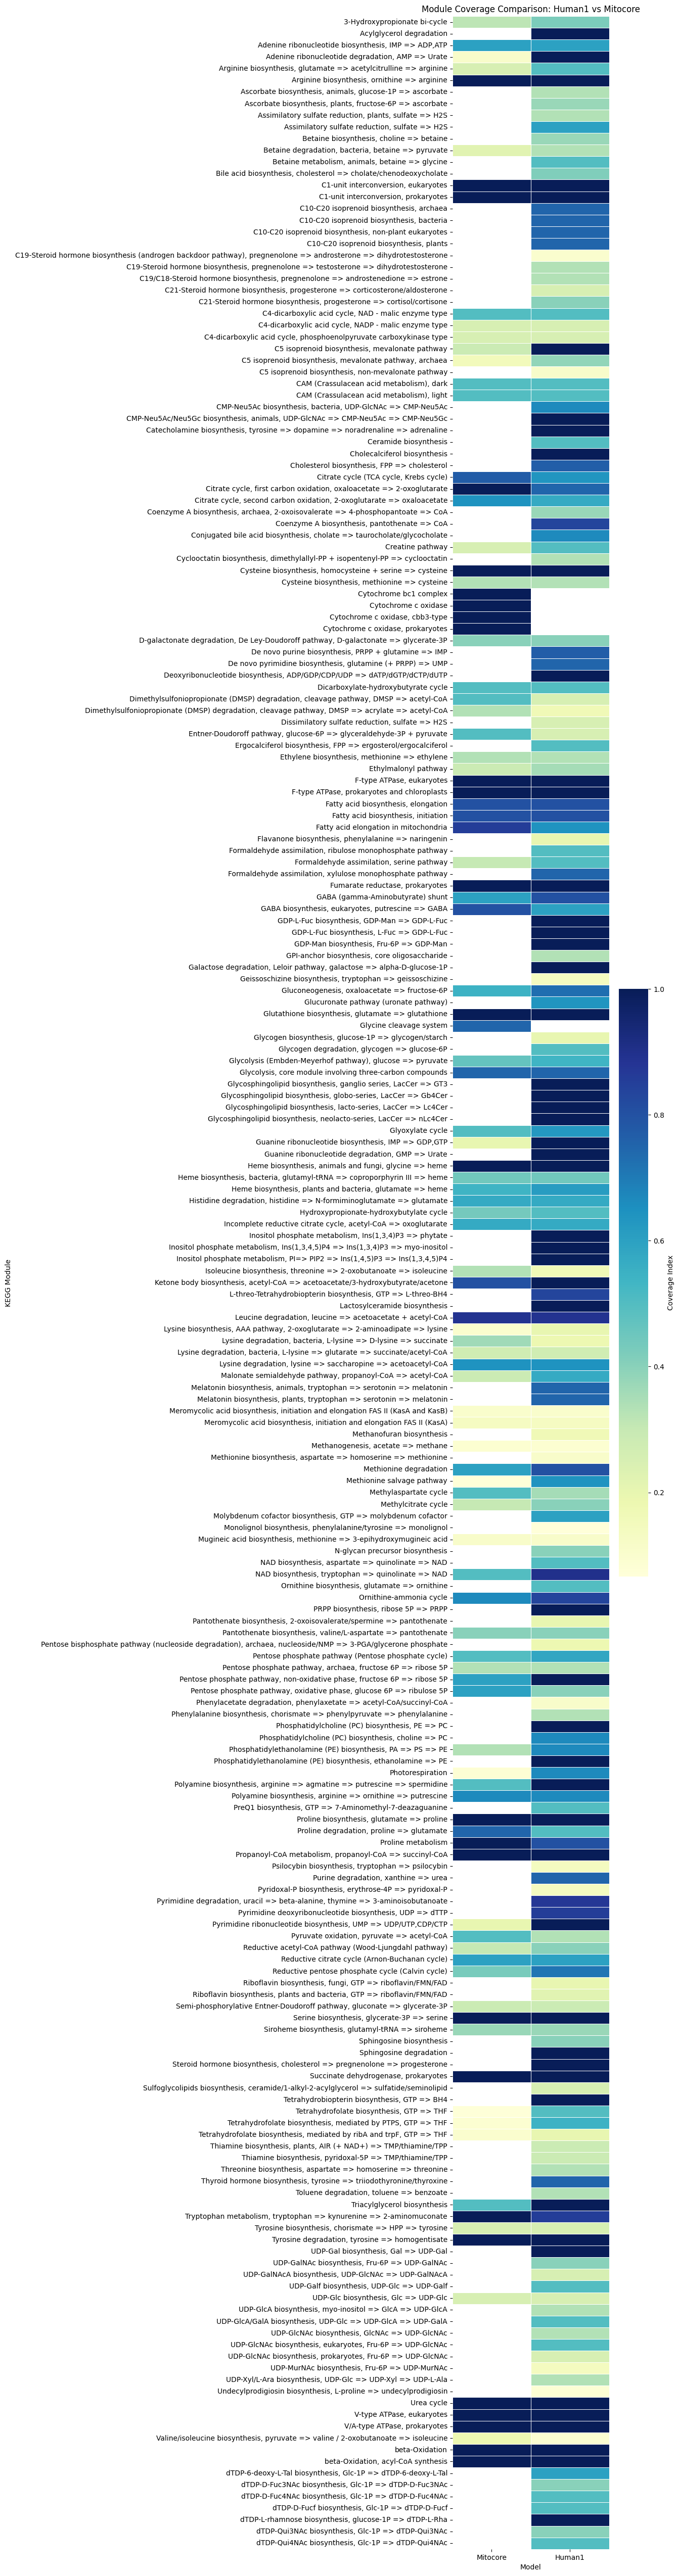

In [ ]:
# 4. Plot coverage index
import seaborn as sns
import matplotlib.pyplot as plt

# specify column names because heatmap needs numerical values
#df=df_combined.iloc[['Human1', 'Mitocore']]

plt.figure(figsize=(10, 8))
# Select only numerical columns for the heatmap
heatmap_data = df_combined[['Mitocore', 'Human1']]

plt.figure(figsize=(5, len(heatmap_data) * 0.3)) # Adjust height to number of modules
sns.heatmap(
    heatmap_data,
    annot=False,  # show numbers inside cells
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Coverage Index'}
)
plt.title("Module Coverage Comparison: Human1 vs Mitocore")
plt.ylabel("KEGG Module")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# Use just modules from Mitocore and Human1 included in Mitocore

Just for Masters thesis: 
    the graphics need to fit in just one page so just Mitocore modules taken.

Leave API requests and already generated csv files calls out.

1. read csv files with Mitocore and Human1 modules and unite statistics
2. Select just Human1 modules present in Mitocore -->  differential step from previous workflow
3. Presence-absence array per KEGG modules
4. Plot presence-absence map



In [ ]:
# 1. read modules for Mitocore and Human1 from API request 
modules_mito= pd.read_csv('kegg.module_mitocore.csv')
modules_human1= pd.read_csv('kegg.module_human1.csv')
print('mito total:', len(modules_mito))
print('mito withouth duplicates:', len(modules_mito.drop_duplicates()))
print('human1 total:', len(modules_human1))
print('human1 withouth duplicates:', len(modules_human1.drop_duplicates()))


# 2. Collect human1 modules present in Mitocore 
common_modules = {'kegg.module': [], 'module_name': []}
mito_modules = set(modules_mito['kegg.module'].dropna())

for index , row in modules_human1.iterrows():
    module = row['kegg.module']
    name = row['module_name']
    if pd.notna(module) and module in mito_modules:
        common_modules['kegg.module'].append(module)
        common_modules['module_name'].append(name)

# Create the output DataFrame and save to csv
common_df = pd.DataFrame(common_modules)
common_df.to_csv('common_modules.csv', index=False)
print('Common modules found:', len(common_df))
print('Common modules without duplicates:', len(common_df.drop_duplicates()))
print("after:", common_df.head())

#dataframe with all modules Mitocore # Human1 withouth duplicates
total_modules= extract_modules(modules_mito,common_df)
total_modules= total_modules.drop_duplicates()
print('total after droping duplicates:', len(total_modules))
print(total_modules)


mito total: 538
mito withouth duplicates: 538
human1 total: 2186
human1 withouth duplicates: 2181
Common modules found: 581
Common modules without duplicates: 103
after:   kegg.module                                        module_name
0      M00357                 Methanogenesis, acetate => methane
1      M00357                 Methanogenesis, acetate => methane
2      M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...
3      M00165   Reductive pentose phosphate cycle (Calvin cycle)
4      M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...
total after droping duplicates: 108
     module                                        module name
0    M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...
1    M00549               UDP-Glc biosynthesis, Glc => UDP-Glc
3    M00002  Glycolysis, core module involving three-carbon...
4    M00003       Gluconeogenesis, oxaloacetate => fructose-6P
5    M00165   Reductive pentose phosphate cycle (Calvin cycle)
..      ...               

# Presence-absence array per KEGG modules
In this dataframe since for Human1 are just modules that are also present in Mitocore, the result should show 100% presence of these modules for Mitocore.

In [ ]:
# 3. Presence-absence array per KEGG modules

#dictionary, catch flags in modules for the respective model
mitocore_flags = []
human1_flags = [] 

# discard duplicates from the modules
mito_modules = set(modules_mito['kegg.module'])
human1_modules = set(common_df['kegg.module'])

#extract 'modules' row from df for all modules (Humanq1 + Mitocore)
for index, row in total_modules.iterrows():
    module = row['module']
    #conditional = 1 if module in total modules in Mitocore or Human1 
    mitocore_flags.append(1 if module in mito_modules else 0)
    human1_flags.append(1 if module in human1_modules else 0)

# Add new columns to dataframe
total_modules['Mitocore'] = mitocore_flags
total_modules['Human1'] = human1_flags

print(total_modules)


     module                                        module name  Mitocore  \
0    M00001  Glycolysis (Embden-Meyerhof pathway), glucose ...         1   
1    M00549               UDP-Glc biosynthesis, Glc => UDP-Glc         1   
3    M00002  Glycolysis, core module involving three-carbon...         1   
4    M00003       Gluconeogenesis, oxaloacetate => fructose-6P         1   
5    M00165   Reductive pentose phosphate cycle (Calvin cycle)         1   
..      ...                                                ...       ...   
414  M00846   Siroheme biosynthesis, glutamyl-tRNA => siroheme         1   
416  M00926  Heme biosynthesis, bacteria, glutamyl-tRNA => ...         1   
434  M00089                       Triacylglycerol biosynthesis         1   
436  M00093  Phosphatidylethanolamine (PE) biosynthesis, PA...         1   
437  M00052  Pyrimidine ribonucleotide biosynthesis, UMP =>...         1   

     Human1  
0         1  
1         1  
3         1  
4         1  
5         1  
.. 


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20

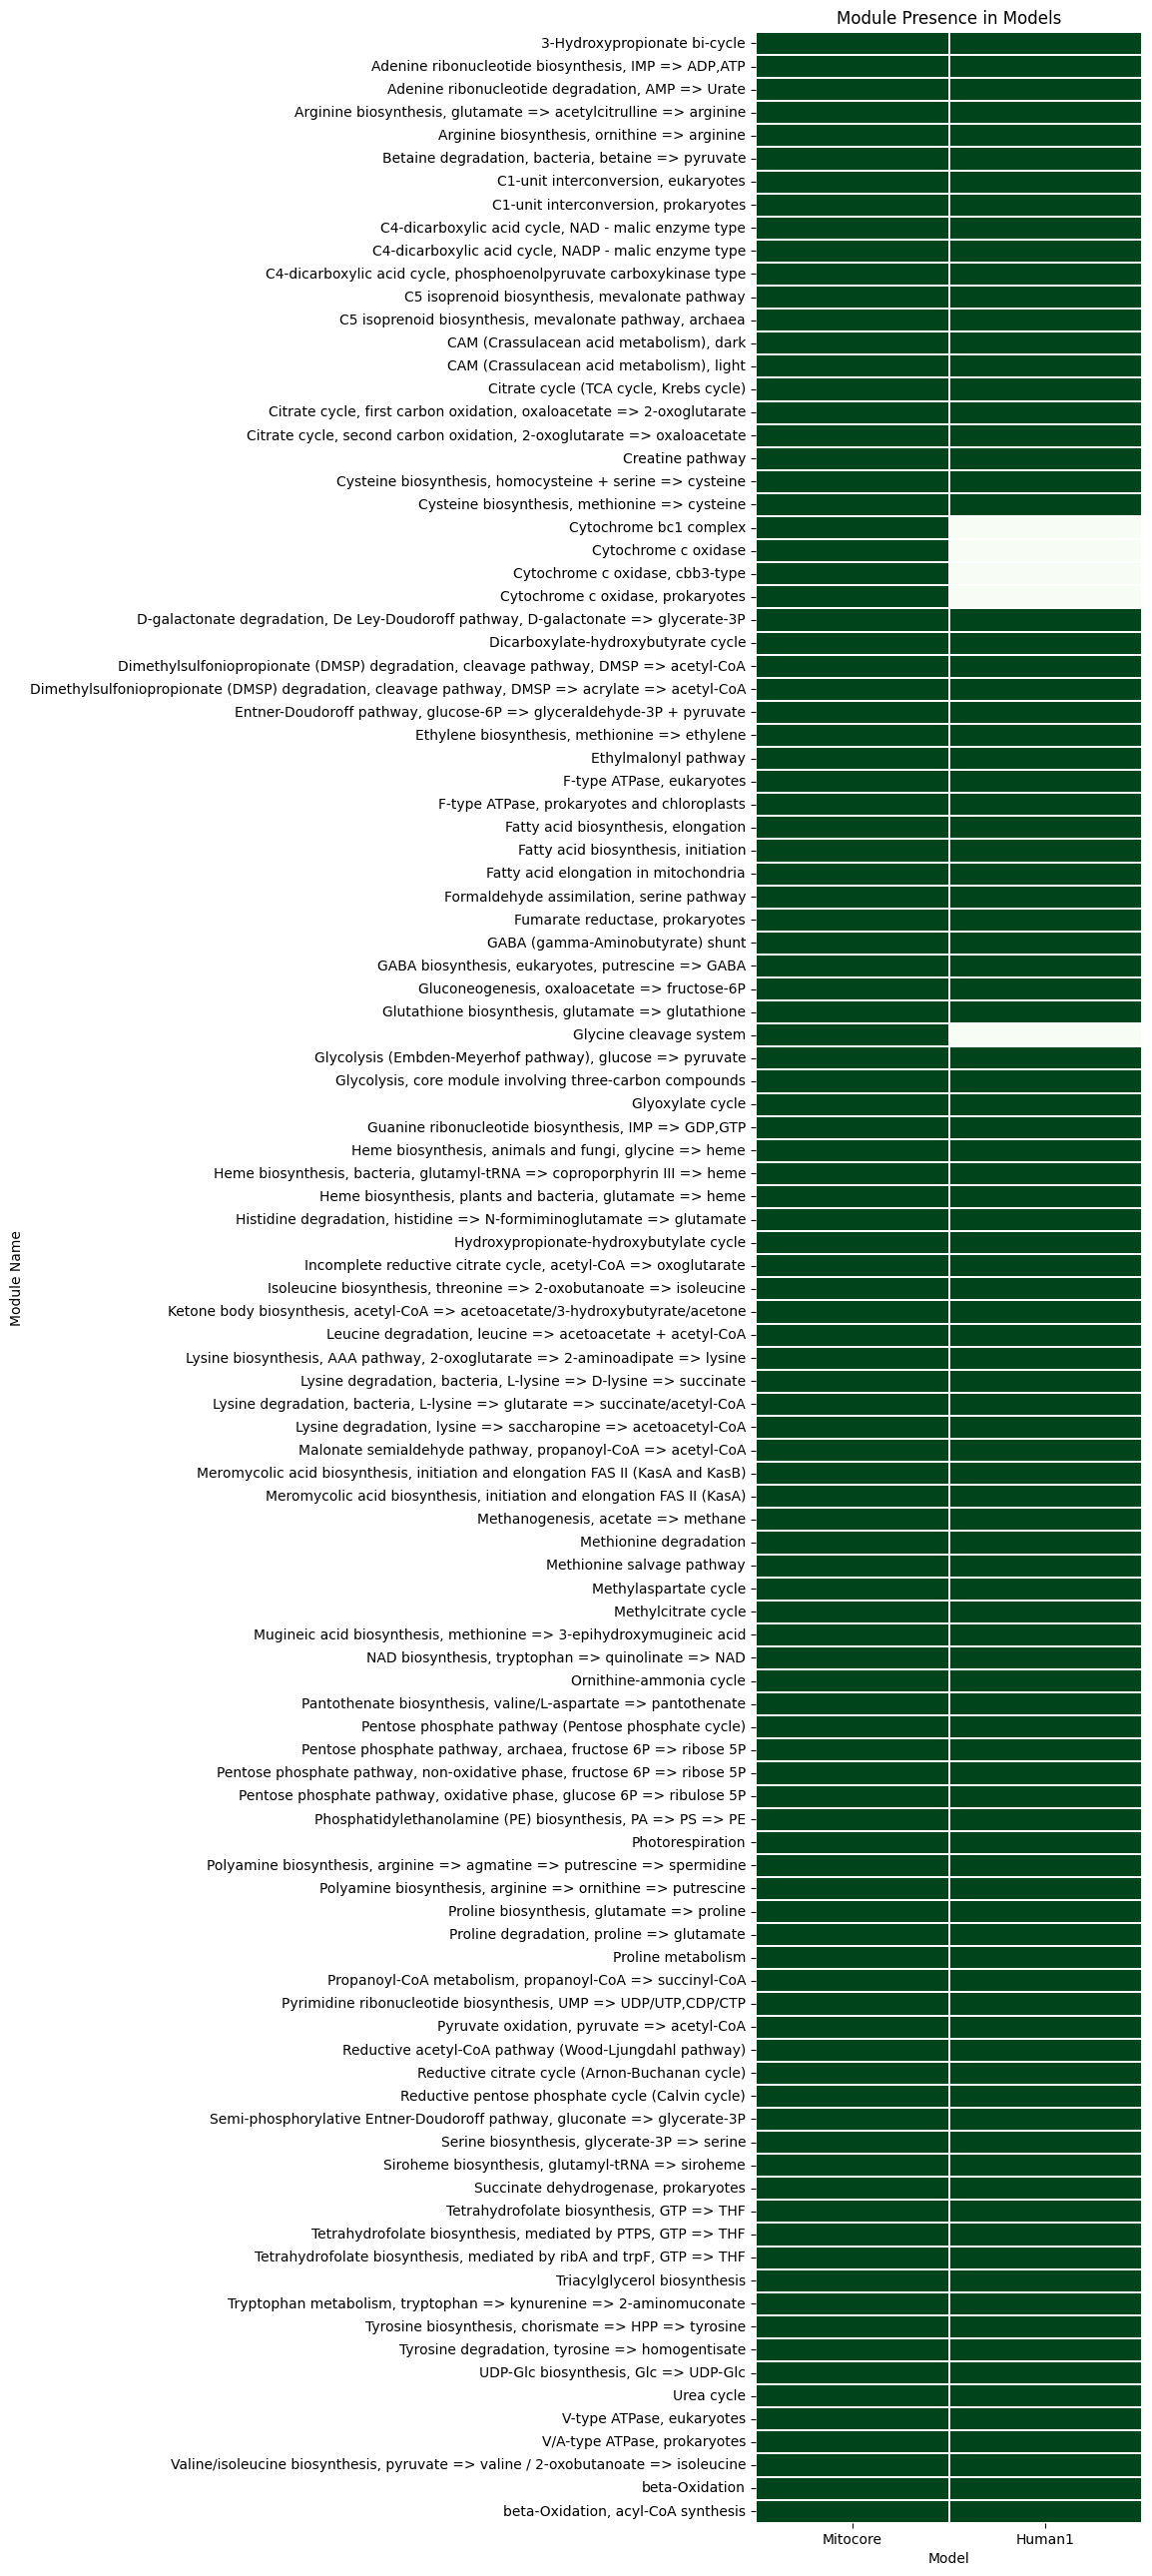

In [ ]:
# 4. Plot presence-absence map
%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
print(plt.colormaps())

heatmap_data = total_modules.set_index('module name')[['Mitocore', 'Human1']]
data_sorted = heatmap_data.sort_index(axis=0)# sorting by module name (just rows)

# Create the heatmap
plt.figure(figsize=(5, len(heatmap_data) * 0.3))  # Adjust height to number of modules
sns.heatmap(data_sorted, cmap='Greens', cbar=False, linewidths=0.1)

plt.title('Module Presence in Models')
plt.xlabel('Model')
plt.ylabel('Module Name')
plt.show()

# KEGG Module coverage per model as Heatmap 

1. Create dataframe with all modules (just Mitocore and Human1 present in Mitocore)
2. Create dictionary with module as key and all reactions as values such as --> {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
3. Calculate coverage index
4. Plot coverage index as heatmap

In [ ]:
# 1. Create dataframe with all modules (just Mitocore and Human1 present in Mitocore)
modules_total = list(total_modules['module'])
modules_total_df = pd.DataFrame(modules_total, columns=['module'])
print(modules_total_df)

     module
0    M00001
1    M00549
2    M00002
3    M00003
4    M00165
..      ...
103  M00846
104  M00926
105  M00089
106  M00093
107  M00052

[108 rows x 1 columns]


In [ ]:
# 2. Create dictionary with strcture {'M00549': ['R01786, R02189'], 'M00002': ['R01015, R07159']}
module_reactions = pd.read_csv('modules_content.csv') 

import re
pattern = r'R\d{5}'  # Pattern KEGG ids recognition (e.g. R00209)
modules_dict = {}

for index, row in module_reactions.iterrows():
    module = row['module_id']
    reactions = row['reactions']
    matches = re.findall(pattern, reactions)  # re.findall() works just with str
    if matches:
        if module not in modules_dict:
            modules_dict[module] = []  # Initialize the list for the module
        modules_dict[module].append(', '.join(matches))  # Join matches into a single string

print(modules_dict)

{'M00001': ['R01786, R02189, R09085, R13199, R00756, R05805, R01068, R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00549': ['R01786, R02189, R00959, R00289'], 'M00002': ['R01015, R01061, R01063, R01512, R07159, R01518, R00658, R00200'], 'M00003': ['R00431, R00726, R00341, R00658, R01518, R01512, R01061, R01063, R01015, R01068, R00762'], 'M00165': ['R01523, R00024, R01512, R01061, R01063, R01015, R01068, R00762, R01067, R01829, R01845, R01641, R01056, R01529'], 'M00308': ['R01538, R01541, R05605, R01061, R01512, R01058, R10860'], 'M00552': ['R03033, R03387, R01064, R01061, R01512'], 'M00346': ['R00945, R00588, R01388, R08572, R00658, R00345, R00342, R01256, R00473, R00588'], 'M00004': ['R02736, R10907, R02035, R01528, R10221, R01529, R01056, R01641, R08575, R01067, R13199, R02739'], 'M00006': ['R02736, R10907, R02035, R01528, R10221'], 'M00008': ['R02736, R02035, R02036, R05605'], 'M00007': ['R01067, R08575, R01641, R01529, R01056'], 'M00580': ['R05339, R05338, R01

In [132]:
# 3. calculate coverage index
modules_mito=module_coverage_index('kegg_reactions_mito.csv', modules_dict, 'kegg.module_mitocore.csv' )
modules_hum=module_coverage_index('kegg_reactions_human1.csv', modules_dict, 'common_modules.csv' )

modules_mito = modules_mito.rename(columns={'coverage': 'Mitocore'})
modules_hum = modules_hum.rename(columns={'coverage': 'Human1'})

# Merge on module id, keep all modules from both models
df_combined = pd.merge(
    modules_mito[['module id','module name', 'Mitocore']],modules_hum[['module id', 'module name', 'Human1']],on='module name',how='outer' )

# Set 'module name' as index for plotting and sort by module name(rows alphabetically)
df_combined = df_combined.set_index('module name').sort_index(axis=0)
print('lenght:', len(df_combined), df_combined)


module M00001 has 15 reactions
module M00549 has 4 reactions
module M00002 has 8 reactions
module M00003 has 11 reactions
module M00165 has 14 reactions
module M00308 has 7 reactions
module M00552 has 5 reactions
module M00346 has 10 reactions
module M00004 has 12 reactions
module M00006 has 5 reactions
module M00008 has 4 reactions
module M00007 has 5 reactions
module M00580 has 3 reactions
module M00307 has 6 reactions
module M00009 has 22 reactions
module M00010 has 8 reactions
module M00012 has 8 reactions
module M00740 has 14 reactions
module M00173 has 15 reactions
module M00011 has 14 reactions
module M00374 has 14 reactions
module M00620 has 7 reactions
module M00376 has 19 reactions
module M00982 has 10 reactions
module M00168 has 2 reactions
module M00171 has 8 reactions
module M00149 has 1 reactions
module M00150 has 1 reactions
module M00152 has 1 reactions
module M00154 has 1 reactions
module M00155 has 1 reactions
module M00156 has 1 reactions
module M00157 has 1 reaction

/var/folders/9p/_1828r2n5gb11k82139j3hz00000gn/T/ipykernel_1141/1536958301.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


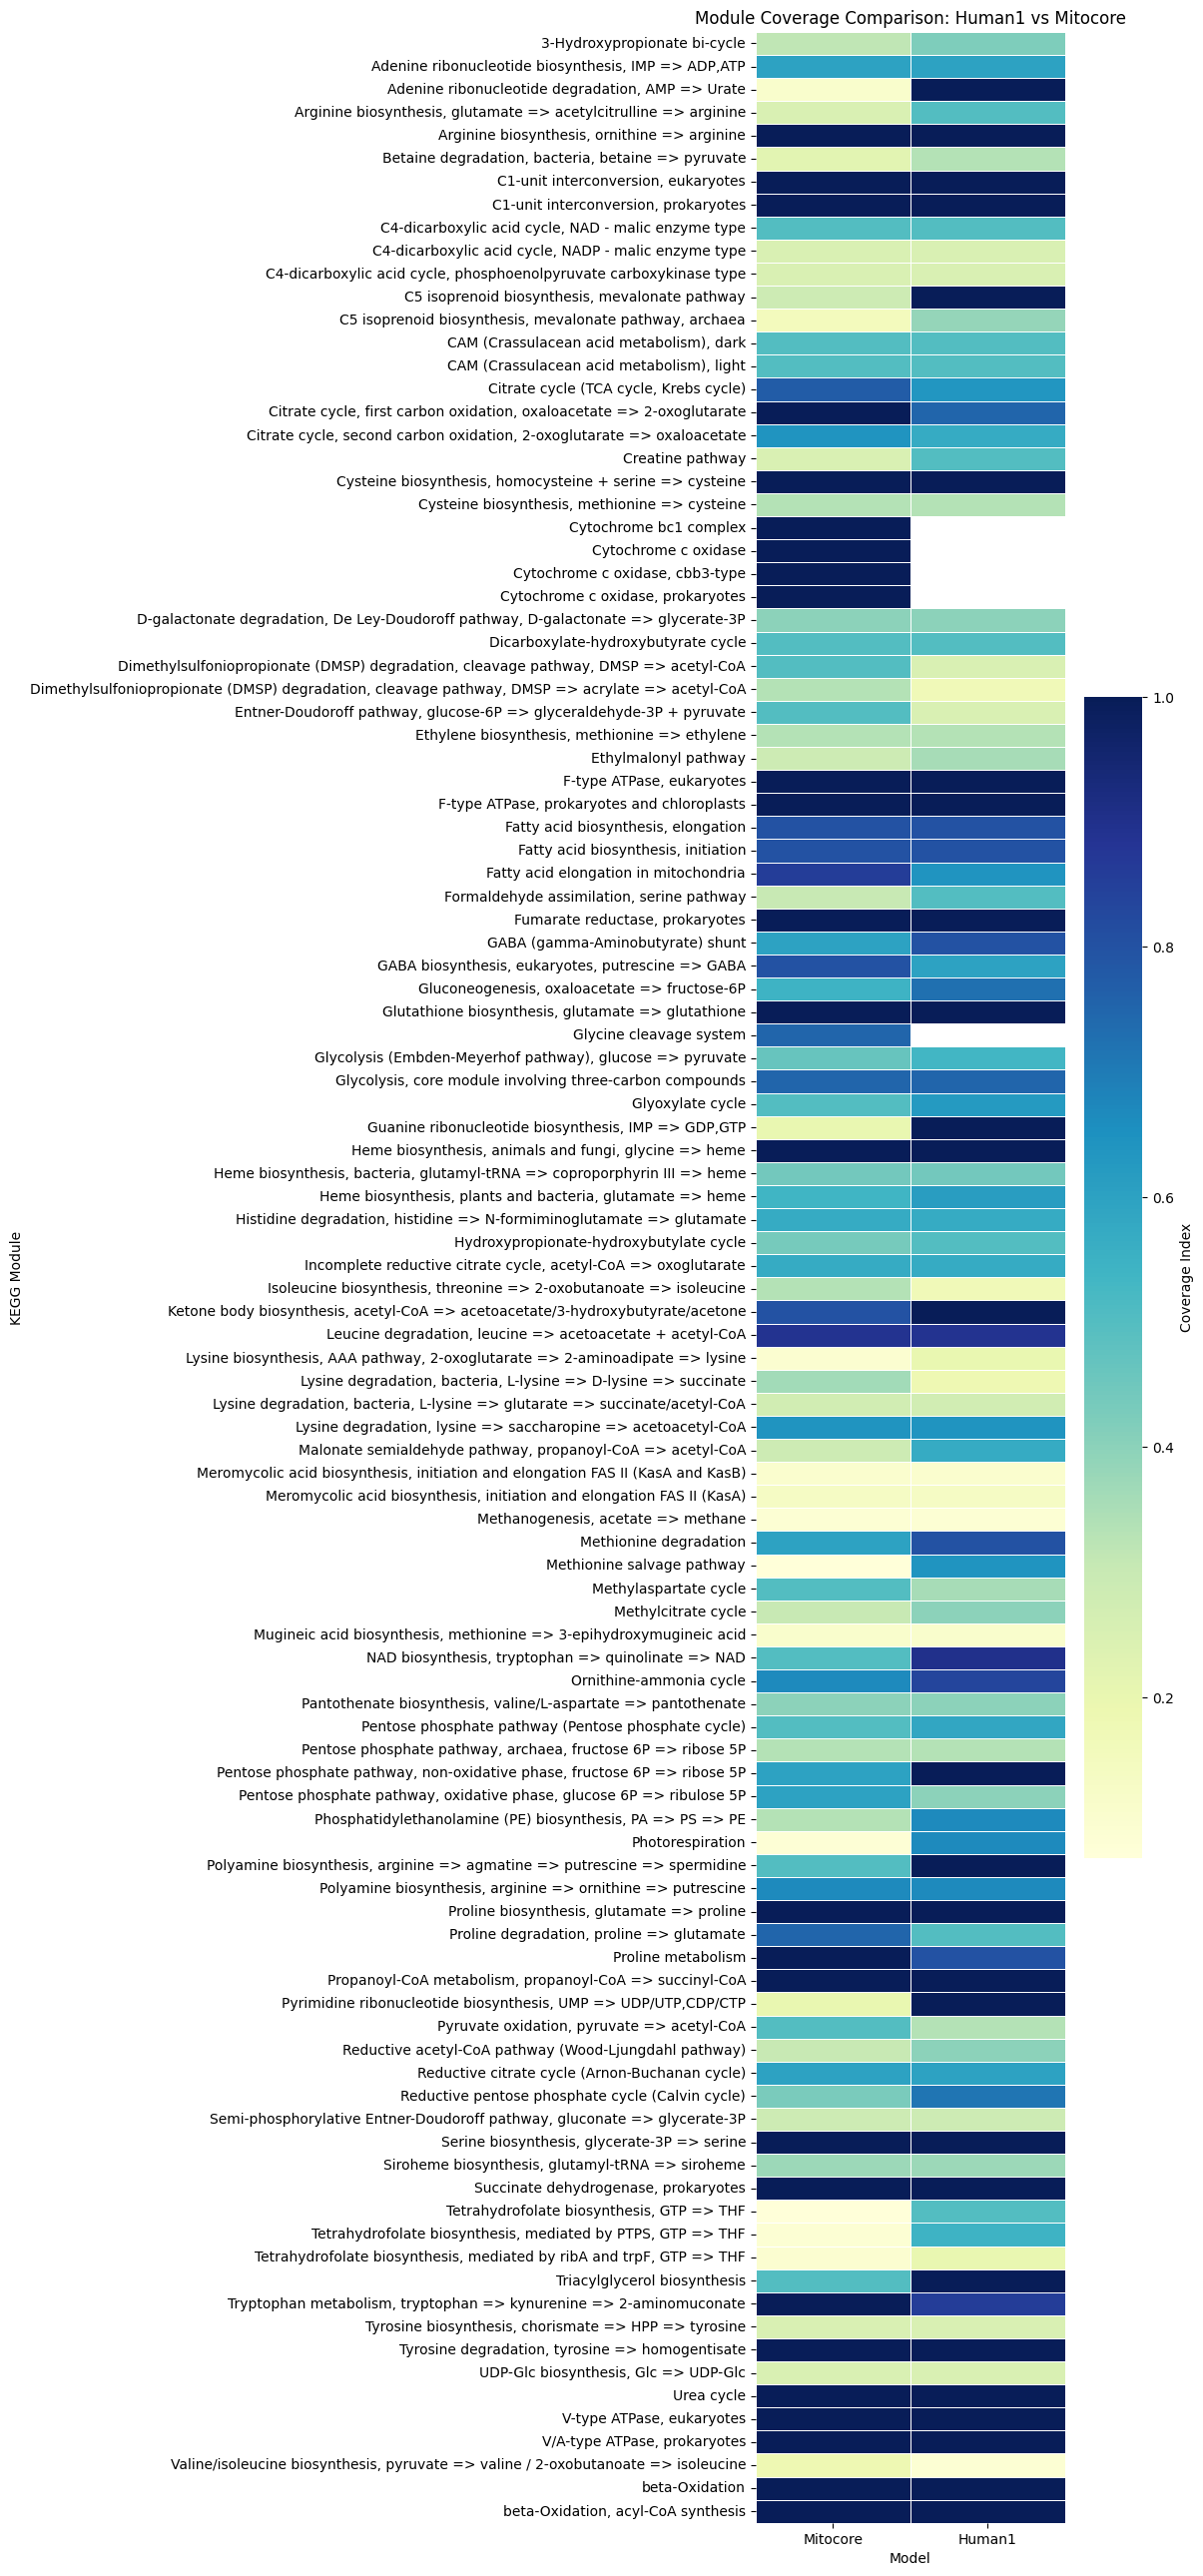

In [ ]:
# Plot coverage index as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# specify column names because heatmap needs numerical values
df = df_combined[['Mitocore', 'Human1']]

plt.figure(figsize=(5, len(df) * 0.3))  # Adjust height to number of modules
sns.heatmap(df, annot=False, cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Coverage Index'}
)
plt.title("Module Coverage Comparison: Human1 vs Mitocore")
plt.ylabel("KEGG Module")
plt.xlabel("Model")
plt.tight_layout()
plt.show()